# DL Homework #1

**Задача:** рассмотреть распределение активаций в CNN на датасетах MNIST, Fashion-MNIST, Kuzushiji-MNIST в зависимости от архитектурных параметров, BN, DN, оптимизатора.

## Импорты

In [265]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [266]:
#!g1.1
SEED = 1234
ROOT = '.data'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [267]:
#!g1.1
device = ("cuda" if torch.cuda.is_available() else "cpu") 

### Данные

Проведём эксперименты на датасетах MNIST (10 рукописных цифр), Fashion-MNIST (10 видов одежды) и Kuzushiji-MNIST (10 символов хираганы). Все они состоят из одноканальных изображений размером 28 $\times$ 28 пикселей.

#### MNIST

In [268]:
#!g1.1
VALID_RATIO = 0.9
BATCH_SIZE = 64

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_iterator_1 = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator_1 = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator_1 = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw


Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


#### FMNIST

In [269]:
#!g1.1
VALID_RATIO = 0.9
BATCH_SIZE = 64

train_data = datasets.FashionMNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_iterator_2 = data.DataLoader(train_data,
                                   shuffle=True,
                                   batch_size=BATCH_SIZE)

valid_iterator_2 = data.DataLoader(valid_data,
                                   batch_size=BATCH_SIZE)

test_iterator_2 = data.DataLoader(test_data,
                                  batch_size=BATCH_SIZE)


Extracting .data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .data/FashionMNIST/raw


Extracting .data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .data/FashionMNIST/raw


Extracting .data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .data/FashionMNIST/raw


Extracting .data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .data/FashionMNIST/raw

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [270]:
#!g1.1
VALID_RATIO = 0.9
BATCH_SIZE = 64

train_data = datasets.KMNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_iterator_3 = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator_3 = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator_3 = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)


Extracting .data/KMNIST/raw/train-images-idx3-ubyte.gz to .data/KMNIST/raw


Extracting .data/KMNIST/raw/train-labels-idx1-ubyte.gz to .data/KMNIST/raw


Extracting .data/KMNIST/raw/t10k-images-idx3-ubyte.gz to .data/KMNIST/raw


Extracting .data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to .data/KMNIST/raw

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


## Вспомогательные функции

Ниже приведены функции для обучения и оценки модели:

In [271]:
#!g1.1
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [272]:
#!g1.1
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [273]:
#!g1.1
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [274]:
#!g1.1
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
    
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [275]:
#!g1.1
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [334]:
#!g1.1
def train_model(model, name, n_epochs, train_iterator, valid_iterator, opt='Adam'):
    optimizer=None
    if opt=='Adam':
        optimizer = optim.Adam(model.parameters())
    elif opt=='SGD':
        optimizer = optim.SGD(model.parameters(), lr=10e-3, momentum=0.9)
    else:
        assert 0 == 1

    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)

    best_valid_loss = float('inf')

    for epoch in trange(n_epochs, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{name}.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [285]:
#!g1.1
def get_activations(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model = model.to(device)
    criterion = criterion.to(device)
    
    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    activations = model.activations
    activations = [a.to('cpu').flatten() for a in activations]
    activations = torch.cat(activations).detach().numpy()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), activations

### Модель

Используем для исследования архитектуру LeNet. По умолчанию она состоит из 2-х последовательных свёрточных слоёв с активацией и пулингом для выделения признаков и 3-х последовательных полносвязных слоёв для классификации. Также по умолчанию: сеть инициализируется с помощью Kaiming Normal Initialization и обучается с помощью оптимизатора Adam. Обучение происходит 10 эпох.

Рассмотрим и сравним следующие сети:
1. LeNet и LeNet + BatchNorm
2. LeNet и LeNet + DropOut
3. LeNet + Kaiming Initialization и LeNet + Xavier initialization
4. LeNet optimized by Adam и LeNet optimized by SGD
5. Wide LeNet и Narrow LeNet
6. Deep LeNet и Shallow LeNet

Для каждого из пунктов проведём обучение и выведем активации на тестировании. Будем выводить ненулевые активации ($> 10e-7$), но будем вести подсчёт нулевых активаций. Модели и даталоадеры в именах в конце имеют добавку через дефис: '-1', '-2', '-3'. Что означает, что модель с таким же даталоадером: на MNIST, FMNIST или KMNIST.

In [276]:
#!g1.1
class LeNet(nn.Module):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=256, out_features=120)
        self.lin2 = nn.Linear(in_features=120, out_features=84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x
    
    def init_weights(self, init_mode):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if init_mode == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight, mode='fan_in',
                                             nonlinearity='relu')
                elif init_mode == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight, mode='fan_in',
                                            nonlinearity='relu')
                elif init_mode == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                elif init_mode == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                else:
                    m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()

class LeNet_bn(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=256, out_features=120)
        self.bn3 = nn.BatchNorm1d(120)
        self.lin2 = nn.Linear(in_features=120, out_features=84)
        self.bn4 = nn.BatchNorm1d(84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.bn3(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.bn4(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x

class LeNet_do(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []
        self.do_p = 0.25
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.do1 = nn.Dropout(self.do_p)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.do2 = nn.Dropout(self.do_p)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=256, out_features=120)
        self.do3 = nn.Dropout(self.do_p)
        self.lin2 = nn.Linear(in_features=120, out_features=84)
        self.do4 = nn.Dropout(self.do_p)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.do1(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.do2(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        x = self.do3(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.do4(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x
    
class LeNet_wide(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=512, out_features=240)
        self.lin2 = nn.Linear(in_features=240, out_features=84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x
        
class LeNet_narrow(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=160, out_features=100)
        self.lin2 = nn.Linear(in_features=100, out_features=84)
        self.lin3 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.softmax(x, dim=1)
        return x

class LeNet_deep(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=256, out_features=160)
        self.lin2 = nn.Linear(in_features=160, out_features=120)
        self.lin3 = nn.Linear(in_features=120, out_features=84)
        self.lin4 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.conv3(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin3(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin4(x)
        x = F.softmax(x, dim=1)
        return x
    
class LeNet_shallow(LeNet):
    def __init__(self, output_dim, init_mode='kaiming_normal'):
        super(LeNet, self).__init__()
        
        self.activations = []

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=250, out_features=84)
        self.lin2 = nn.Linear(in_features=84, out_features=output_dim)
        
        self.init_weights(init_mode)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)
        self.activations.append(x)
        x = self.lin2(x)
        x = F.softmax(x, dim=1)
        return x

In [279]:
#!g1.1
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
n_epochs = 10

### Сравнение моделей

#### LeNet vs LeNet + BatchNorm

MNIST:

In [16]:
#!g1.1
train_iterator = train_iterator_1
valid_iterator = valid_iterator_1
model1 = LeNet(10)
model2 = LeNet_bn(10)
name1 = 'LeNet-1'
name2 = 'LeNet_bn-1'

In [17]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.714 | Train Acc: 75.12%
	 Val. Loss: 1.593 |  Val. Acc: 86.83%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.526 | Train Acc: 93.64%
	 Val. Loss: 1.497 |  Val. Acc: 96.48%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.506 | Train Acc: 95.62%
	 Val. Loss: 1.488 |  Val. Acc: 97.45%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.501 | Train Acc: 96.00%
	 Val. Loss: 1.488 |  Val. Acc: 97.21%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.496 | Train Acc: 96.59%
	 Val. Loss: 1.486 |  Val. Acc: 97.51%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.495 | Train Acc: 96.60%
	 Val. Loss: 1.480 |  Val. Acc: 98.13%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.492 | Train Acc: 96.88%
	 Val. Loss: 1.488 |  Val. Acc: 97.34%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.491 | Train Acc: 96.97%
	 Val. Loss: 1.482 |  Val. Acc: 97.83%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.489 | Train Acc: 97.19%
	 Val. Loss: 1.479 |  Val. Acc: 98.24%
Epoch: 10 | Epoch T

In [18]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 1.568 | Train Acc: 91.58%
	 Val. Loss: 1.490 |  Val. Acc: 97.52%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 1.500 | Train Acc: 96.49%
	 Val. Loss: 1.486 |  Val. Acc: 97.70%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 1.493 | Train Acc: 97.05%
	 Val. Loss: 1.480 |  Val. Acc: 98.18%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 1.488 | Train Acc: 97.40%
	 Val. Loss: 1.480 |  Val. Acc: 98.15%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 1.487 | Train Acc: 97.46%
	 Val. Loss: 1.477 |  Val. Acc: 98.47%
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 1.485 | Train Acc: 97.70%
	 Val. Loss: 1.477 |  Val. Acc: 98.37%
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 1.483 | Train Acc: 97.83%
	 Val. Loss: 1.476 |  Val. Acc: 98.54%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 1.483 | Train Acc: 97.87%
	 Val. Loss: 1.477 |  Val. Acc: 98.48%
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 1.482 | Train Acc: 97.97%
	 Val. Loss: 1.475 |  Val. Acc: 98.76%
Epoch: 10 | Epoch T

FMNIST:

In [40]:
#!g1.1
train_iterator = train_iterator_2
valid_iterator = valid_iterator_2
model1 = LeNet(10)
model2 = LeNet_bn(10)
name1 = 'LeNet-2'
name2 = 'LeNet_bn-2'

In [38]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.719 | Train Acc: 74.80%
	 Val. Loss: 1.581 |  Val. Acc: 88.09%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.556 | Train Acc: 90.66%
	 Val. Loss: 1.494 |  Val. Acc: 96.72%
Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 1.506 | Train Acc: 95.64%
	 Val. Loss: 1.496 |  Val. Acc: 96.65%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.499 | Train Acc: 96.25%
	 Val. Loss: 1.484 |  Val. Acc: 97.80%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 1.495 | Train Acc: 96.60%
	 Val. Loss: 1.483 |  Val. Acc: 97.79%
Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 1.493 | Train Acc: 96.87%
	 Val. Loss: 1.485 |  Val. Acc: 97.65%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.491 | Train Acc: 97.07%
	 Val. Loss: 1.480 |  Val. Acc: 98.19%
Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 1.489 | Train Acc: 97.19%
	 Val. Loss: 1.483 |  Val. Acc: 97.80%
Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 1.488 | Train Acc: 97.29%
	 Val. Loss: 1.478 |  Val. Acc: 98.35%
Epoch: 10 | Epoch T

In [39]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 1.568 | Train Acc: 91.43%
	 Val. Loss: 1.490 |  Val. Acc: 97.41%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 1.501 | Train Acc: 96.36%
	 Val. Loss: 1.485 |  Val. Acc: 97.74%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 1.494 | Train Acc: 96.89%
	 Val. Loss: 1.483 |  Val. Acc: 97.94%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 1.490 | Train Acc: 97.28%
	 Val. Loss: 1.478 |  Val. Acc: 98.35%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 1.487 | Train Acc: 97.52%
	 Val. Loss: 1.482 |  Val. Acc: 97.95%
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 1.484 | Train Acc: 97.77%
	 Val. Loss: 1.477 |  Val. Acc: 98.45%
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 1.483 | Train Acc: 97.87%
	 Val. Loss: 1.476 |  Val. Acc: 98.57%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 1.483 | Train Acc: 97.80%
	 Val. Loss: 1.474 |  Val. Acc: 98.74%
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 1.481 | Train Acc: 98.01%
	 Val. Loss: 1.475 |  Val. Acc: 98.58%
Epoch: 10 | Epoch T

KMNIST:

In [41]:
#!g1.1
train_iterator = train_iterator_2
valid_iterator = valid_iterator_2
model1 = LeNet(10)
model2 = LeNet_bn(10)
name1 = 'LeNet-2'
name2 = 'LeNet_bn-2'

In [42]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 25s
	Train Loss: 1.619 | Train Acc: 85.43%
	 Val. Loss: 1.497 |  Val. Acc: 96.64%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 1.514 | Train Acc: 94.88%
	 Val. Loss: 1.491 |  Val. Acc: 97.07%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 1.505 | Train Acc: 95.75%
	 Val. Loss: 1.483 |  Val. Acc: 97.93%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 1.497 | Train Acc: 96.47%
	 Val. Loss: 1.482 |  Val. Acc: 97.93%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 1.493 | Train Acc: 96.83%
	 Val. Loss: 1.486 |  Val. Acc: 97.58%
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 1.492 | Train Acc: 97.00%
	 Val. Loss: 1.479 |  Val. Acc: 98.25%
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 1.489 | Train Acc: 97.19%
	 Val. Loss: 1.482 |  Val. Acc: 97.94%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 1.489 | Train Acc: 97.27%
	 Val. Loss: 1.479 |  Val. Acc: 98.20%
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 1.489 | Train Acc: 97.28%
	 Val. Loss: 1.478 |  Val. Acc: 98.28%
Epoch: 10 | Epoch T

In [43]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 1.571 | Train Acc: 91.30%
	 Val. Loss: 1.490 |  Val. Acc: 97.49%
Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 1.502 | Train Acc: 96.29%
	 Val. Loss: 1.485 |  Val. Acc: 97.74%
Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 1.494 | Train Acc: 96.91%
	 Val. Loss: 1.478 |  Val. Acc: 98.45%
Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 1.490 | Train Acc: 97.29%
	 Val. Loss: 1.476 |  Val. Acc: 98.57%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 1.488 | Train Acc: 97.46%
	 Val. Loss: 1.476 |  Val. Acc: 98.64%
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 1.485 | Train Acc: 97.76%
	 Val. Loss: 1.476 |  Val. Acc: 98.67%
Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 1.483 | Train Acc: 97.84%
	 Val. Loss: 1.475 |  Val. Acc: 98.60%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 1.482 | Train Acc: 97.98%
	 Val. Loss: 1.475 |  Val. Acc: 98.70%
Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 1.482 | Train Acc: 97.99%
	 Val. Loss: 1.475 |  Val. Acc: 98.64%
Epoch: 10 | Epoch T

#### Результаты

MNIST:

Zero activations on LeNet-1: 28676948/46840000
Zero activations on LeNet_bn-1: 34239823/46840000


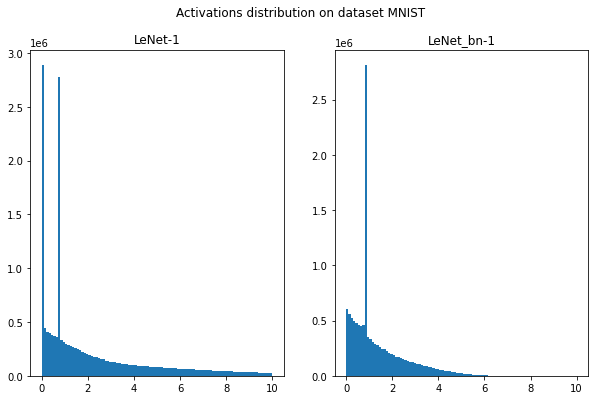

In [44]:
#!g1.1
test_iterator = test_iterator_1
model1 = LeNet(10)
model2 = LeNet_bn(10)
name1 = 'LeNet-1'
name2 = 'LeNet_bn-1'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset MNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

FMNIST:

Zero activations on LeNet-2: 26860901/46840000
Zero activations on LeNet_bn-2: 31321560/46840000


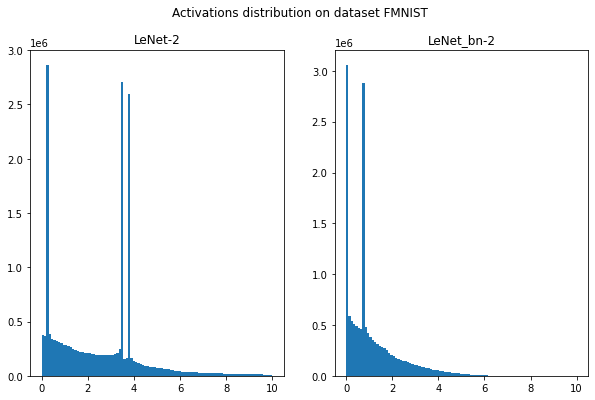

In [63]:
#!g1.1
test_iterator = test_iterator_2
model1 = LeNet(10)
model2 = LeNet_bn(10)
name1 = 'LeNet-2'
name2 = 'LeNet_bn-2'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset FMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

KMNIST:

Zero activations on LeNet-3: 32288783/46840000
Zero activations on LeNet_bn-3: 31618461/46840000


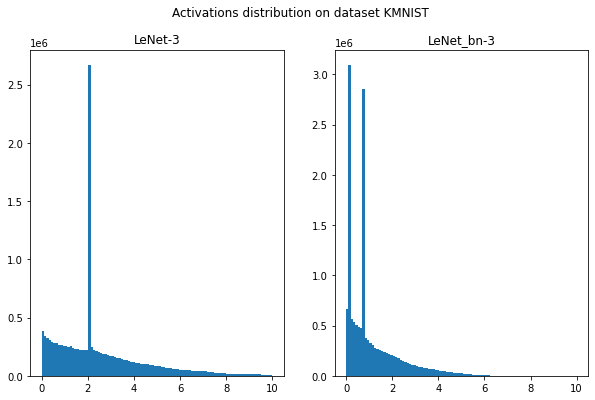

In [64]:
#!g1.1
test_iterator = test_iterator_3
model1 = LeNet(10)
model2 = LeNet_bn(10)
name1 = 'LeNet-3'
name2 = 'LeNet_bn-3'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset KMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

**Вывод:** видно, что BatchNormalization делает распределение активаций похожим на правую половину колокола гауссовского распределения, что и понятно: это суть BN.

#### LeNet vs LeNet + Dropout

Активации для стандартного LeNet уже посчитаны, поэтому задействуем только вторую модель.

MNIST:

In [65]:
#!g1.1
train_iterator = train_iterator_1
valid_iterator = valid_iterator_1
model2 = LeNet_do(10)
name2 = 'LeNet_do-1'

In [66]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.671 | Train Acc: 79.60%
	 Val. Loss: 1.511 |  Val. Acc: 95.31%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.551 | Train Acc: 91.24%
	 Val. Loss: 1.503 |  Val. Acc: 95.93%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.535 | Train Acc: 92.66%
	 Val. Loss: 1.500 |  Val. Acc: 96.19%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.530 | Train Acc: 93.07%
	 Val. Loss: 1.491 |  Val. Acc: 96.99%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.523 | Train Acc: 93.83%
	 Val. Loss: 1.489 |  Val. Acc: 97.24%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.518 | Train Acc: 94.20%
	 Val. Loss: 1.491 |  Val. Acc: 97.04%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.518 | Train Acc: 94.35%
	 Val. Loss: 1.493 |  Val. Acc: 96.85%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.517 | Train Acc: 94.37%
	 Val. Loss: 1.490 |  Val. Acc: 97.09%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.514 | Train Acc: 94.66%
	 Val. Loss: 1.489 |  Val. Acc: 97.21%
Epoch: 10 | Epoch T

FMNIST:

In [89]:
#!g1.1
train_iterator = train_iterator_2
valid_iterator = valid_iterator_2
model2 = LeNet_do(10)
name2 = 'LeNet_do-2'

In [90]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.698 | Train Acc: 76.78%
	 Val. Loss: 1.502 |  Val. Acc: 96.35%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.541 | Train Acc: 92.23%
	 Val. Loss: 1.494 |  Val. Acc: 96.75%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.525 | Train Acc: 93.69%
	 Val. Loss: 1.486 |  Val. Acc: 97.52%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.517 | Train Acc: 94.46%
	 Val. Loss: 1.486 |  Val. Acc: 97.64%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.511 | Train Acc: 95.05%
	 Val. Loss: 1.484 |  Val. Acc: 97.74%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.510 | Train Acc: 95.17%
	 Val. Loss: 1.483 |  Val. Acc: 97.92%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.508 | Train Acc: 95.35%
	 Val. Loss: 1.483 |  Val. Acc: 97.80%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.506 | Train Acc: 95.56%
	 Val. Loss: 1.479 |  Val. Acc: 98.20%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.505 | Train Acc: 95.65%
	 Val. Loss: 1.476 |  Val. Acc: 98.50%
Epoch: 10 | Epoch T

KMNIST:

In [17]:
#!g1.1
train_iterator = train_iterator_3
valid_iterator = valid_iterator_3
model2 = LeNet_do(10)
name2 = 'LeNet_do-3'

In [18]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.716 | Train Acc: 74.98%
	 Val. Loss: 1.514 |  Val. Acc: 95.24%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.551 | Train Acc: 91.17%
	 Val. Loss: 1.500 |  Val. Acc: 96.19%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.533 | Train Acc: 92.91%
	 Val. Loss: 1.495 |  Val. Acc: 96.78%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.529 | Train Acc: 93.23%
	 Val. Loss: 1.495 |  Val. Acc: 96.65%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.519 | Train Acc: 94.17%
	 Val. Loss: 1.487 |  Val. Acc: 97.51%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.518 | Train Acc: 94.39%
	 Val. Loss: 1.488 |  Val. Acc: 97.37%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.517 | Train Acc: 94.46%
	 Val. Loss: 1.485 |  Val. Acc: 97.64%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.516 | Train Acc: 94.53%
	 Val. Loss: 1.488 |  Val. Acc: 97.37%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.515 | Train Acc: 94.56%
	 Val. Loss: 1.494 |  Val. Acc: 96.73%
Epoch: 10 | Epoch T

#### Результаты:

MNIST:

Zero activations on LeNet-1: 28676948/46840000
Zero activations on LeNet_do-1: 28532229/46840000


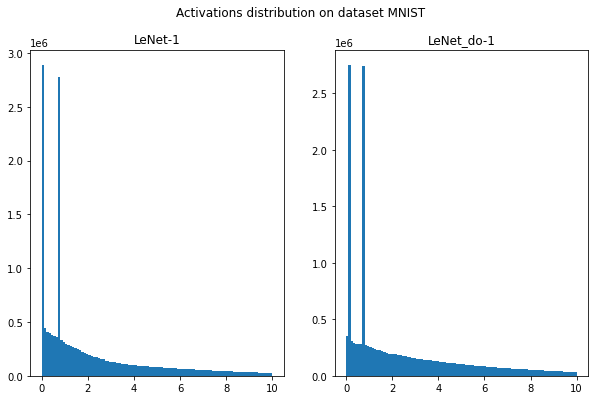

In [37]:
#!g1.1
test_iterator = test_iterator_1
model1 = LeNet(10)
model2 = LeNet_do(10)
name1 = 'LeNet-1'
name2 = 'LeNet_do-1'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset MNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

FMNIST:

Zero activations on LeNet-2: 26860901/46840000
Zero activations on LeNet_do-2: 32064386/46840000


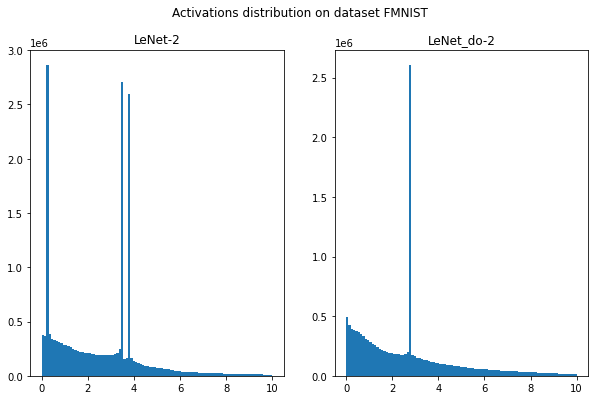

In [38]:
#!g1.1
test_iterator = test_iterator_2
model1 = LeNet(10)
model2 = LeNet_do(10)
name1 = 'LeNet-2'
name2 = 'LeNet_do-2'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset FMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

KMNIST:

Zero activations on LeNet-3: 32288783/46840000
Zero activations on LeNet_do-3: 29520023/46840000


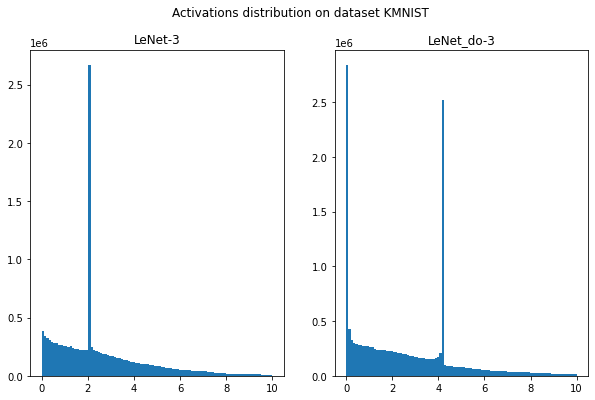

In [39]:
#!g1.1
test_iterator = test_iterator_3
model1 = LeNet(10)
model2 = LeNet_do(10)
name1 = 'LeNet-3'
name2 = 'LeNet_do-3'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset KMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

**Вывод:** Dropout уменьшает пик плотности активаций в нуле, это отчётливо видно по меньшему числу нулевых активаций при Dropout.

#### LeNet + Kaiming Normal Initialization vs LeNet + Xavier Normal Initialization

Опять же, по умолчанию LeNet имеет Kaiming Normal Initialization, поэтому задействуем только вторую модель.

MNIST:

In [40]:
#!g1.1
train_iterator = train_iterator_1
valid_iterator = valid_iterator_1
model2 = LeNet(10, init_mode='xavier_normal')
name2 = 'LeNet_xavnorm-1'

In [41]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.644 | Train Acc: 82.53%
	 Val. Loss: 1.505 |  Val. Acc: 95.87%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.517 | Train Acc: 94.56%
	 Val. Loss: 1.504 |  Val. Acc: 95.81%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.503 | Train Acc: 95.94%
	 Val. Loss: 1.489 |  Val. Acc: 97.25%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.498 | Train Acc: 96.35%
	 Val. Loss: 1.481 |  Val. Acc: 98.02%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.494 | Train Acc: 96.75%
	 Val. Loss: 1.483 |  Val. Acc: 97.91%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.492 | Train Acc: 96.96%
	 Val. Loss: 1.484 |  Val. Acc: 97.74%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.489 | Train Acc: 97.17%
	 Val. Loss: 1.480 |  Val. Acc: 98.12%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.489 | Train Acc: 97.23%
	 Val. Loss: 1.483 |  Val. Acc: 97.85%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.487 | Train Acc: 97.44%
	 Val. Loss: 1.480 |  Val. Acc: 98.05%
Epoch: 10 | Epoch T

FMNIST:

In [42]:
#!g1.1
train_iterator = train_iterator_2
valid_iterator = valid_iterator_2
model2 = LeNet(10, init_mode='xavier_normal')
name2 = 'LeNet_xavnorm-2'

In [43]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.713 | Train Acc: 75.36%
	 Val. Loss: 1.583 |  Val. Acc: 87.75%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.550 | Train Acc: 91.28%
	 Val. Loss: 1.492 |  Val. Acc: 96.97%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.503 | Train Acc: 96.01%
	 Val. Loss: 1.484 |  Val. Acc: 97.62%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.496 | Train Acc: 96.60%
	 Val. Loss: 1.480 |  Val. Acc: 98.18%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.493 | Train Acc: 96.90%
	 Val. Loss: 1.479 |  Val. Acc: 98.29%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.490 | Train Acc: 97.19%
	 Val. Loss: 1.484 |  Val. Acc: 97.76%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.488 | Train Acc: 97.33%
	 Val. Loss: 1.481 |  Val. Acc: 97.97%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.486 | Train Acc: 97.47%
	 Val. Loss: 1.483 |  Val. Acc: 97.88%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.485 | Train Acc: 97.59%
	 Val. Loss: 1.479 |  Val. Acc: 98.30%
Epoch: 10 | Epoch T

KMNIST:

In [45]:
#!g1.1
train_iterator = train_iterator_3
valid_iterator = valid_iterator_3
model2 = LeNet(10, init_mode='xavier_normal')
name2 = 'LeNet_xavnorm-3'

In [46]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.646 | Train Acc: 82.37%
	 Val. Loss: 1.507 |  Val. Acc: 95.61%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.523 | Train Acc: 94.05%
	 Val. Loss: 1.498 |  Val. Acc: 96.39%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.509 | Train Acc: 95.38%
	 Val. Loss: 1.491 |  Val. Acc: 97.15%
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.502 | Train Acc: 96.03%
	 Val. Loss: 1.489 |  Val. Acc: 97.37%
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.499 | Train Acc: 96.27%
	 Val. Loss: 1.493 |  Val. Acc: 96.90%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.495 | Train Acc: 96.72%
	 Val. Loss: 1.484 |  Val. Acc: 97.82%
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.493 | Train Acc: 96.79%
	 Val. Loss: 1.488 |  Val. Acc: 97.40%
Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.491 | Train Acc: 97.02%
	 Val. Loss: 1.481 |  Val. Acc: 98.05%
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.490 | Train Acc: 97.13%
	 Val. Loss: 1.480 |  Val. Acc: 98.12%
Epoch: 10 | Epoch T

#### Результаты:

Zero activations on LeNet-1: 28676948/46840000
Zero activations on LeNet_xavnorm-1: 23108104/46840000


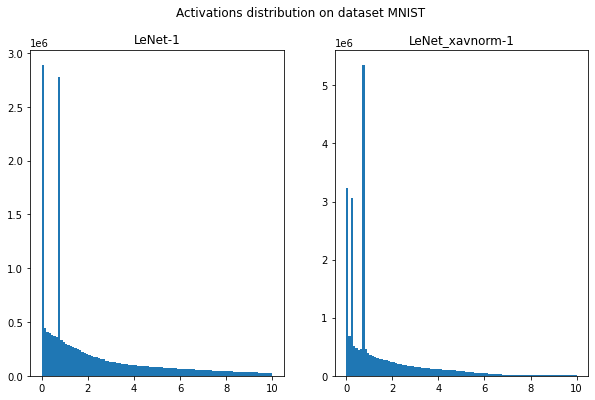

In [281]:
#!g1.1
test_iterator = test_iterator_1
model1 = LeNet(10)
model2 = LeNet(10, init_mode='xavier_normal')
name1 = 'LeNet-1'
name2 = 'LeNet_xavnorm-1'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset MNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

Zero activations on LeNet-2: 26860901/46840000
Zero activations on LeNet_xavnorm-2: 29295454/46840000


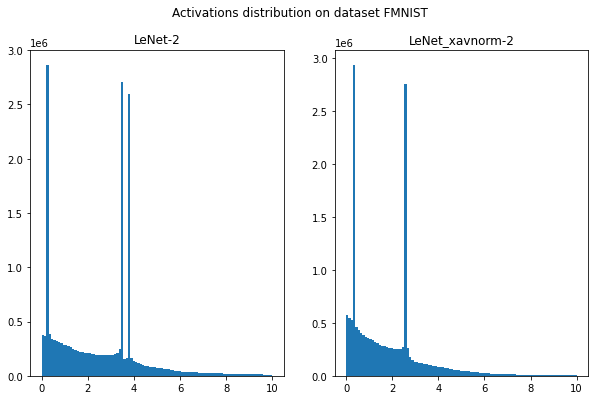

In [282]:
#!g1.1
test_iterator = test_iterator_2
model1 = LeNet(10)
model2 = LeNet(10, init_mode='xavier_normal')
name1 = 'LeNet-2'
name2 = 'LeNet_xavnorm-2'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset FMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

Zero activations on LeNet-3: 32288783/46840000
Zero activations on LeNet_xavnorm-3: 27510919/46840000


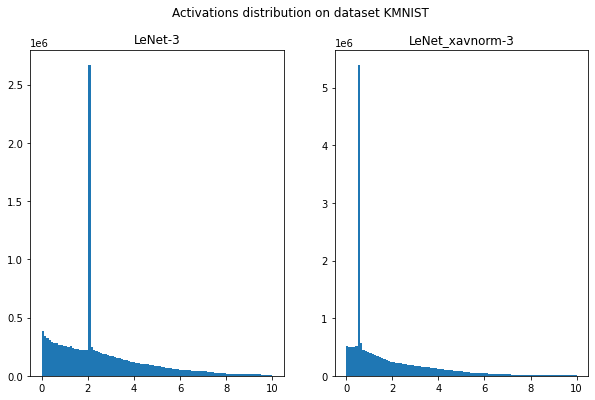

In [283]:
#!g1.1
test_iterator = test_iterator_3
model1 = LeNet(10)
model2 = LeNet(10, init_mode='xavier_normal')
name1 = 'LeNet-3'
name2 = 'LeNet_xavnorm-3'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset KMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

**Вывод:** на всех трёх датасетах подтверждается, что в отличие от Kaiming Normal Initialization, Xavier Normal Initialization имеет более короткие хвосты, меньшую дисперсию, а соответственно и большую плотность ближе к 0: как будто распределение немного ужали к нулю.

#### Adam vs SGD

По умолчанию LeNet оптимизоравлась с помощью Adam. Посмотрим на оптимизацию с помощью SGD c `lr=10e-5, momentum=0.9`:

MNIST:

In [330]:
#!g1.1
train_iterator = train_iterator_1
valid_iterator = valid_iterator_1
model2 = LeNet(10)
name2 = 'LeNet_sgd-1'

In [335]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator, opt='SGD')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.861 | Train Acc: 61.58%
	 Val. Loss: 1.691 |  Val. Acc: 76.96%


Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.694 | Train Acc: 76.81%
	 Val. Loss: 1.678 |  Val. Acc: 78.19%


Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.619 | Train Acc: 84.41%
	 Val. Loss: 1.589 |  Val. Acc: 87.16%


Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.591 | Train Acc: 87.12%
	 Val. Loss: 1.584 |  Val. Acc: 87.63%


Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.583 | Train Acc: 87.86%
	 Val. Loss: 1.577 |  Val. Acc: 88.34%


Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.579 | Train Acc: 88.19%
	 Val. Loss: 1.574 |  Val. Acc: 88.71%


Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.575 | Train Acc: 88.56%
	 Val. Loss: 1.571 |  Val. Acc: 88.92%


Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.573 | Train Acc: 88.77%
	 Val. Loss: 1.574 |  Val. Acc: 88.66%


Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.572 | Train Acc: 88.88%
	 Val. Loss: 1.574 |  Val. Acc: 88.61%


Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 1.571 | Train Acc: 88.91%
	 Val. Loss: 1.573 |  Val. Acc: 88.72%



FMNIST:

In [336]:
#!g1.1
train_iterator = train_iterator_2
valid_iterator = valid_iterator_2
model2 = LeNet(10)
name2 = 'LeNet_sgd-2'

In [337]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator, opt='SGD')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.846 | Train Acc: 62.29%
	 Val. Loss: 1.677 |  Val. Acc: 78.57%


Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.690 | Train Acc: 77.22%
	 Val. Loss: 1.672 |  Val. Acc: 78.72%


Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.643 | Train Acc: 81.94%
	 Val. Loss: 1.577 |  Val. Acc: 88.54%


Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.589 | Train Acc: 87.29%
	 Val. Loss: 1.574 |  Val. Acc: 88.71%


Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.583 | Train Acc: 87.90%
	 Val. Loss: 1.571 |  Val. Acc: 88.98%


Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.579 | Train Acc: 88.16%
	 Val. Loss: 1.571 |  Val. Acc: 88.97%


Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.576 | Train Acc: 88.53%
	 Val. Loss: 1.570 |  Val. Acc: 89.02%


Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.573 | Train Acc: 88.74%
	 Val. Loss: 1.568 |  Val. Acc: 89.20%


Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.518 | Train Acc: 94.46%
	 Val. Loss: 1.480 |  Val. Acc: 98.20%


Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 1.491 | Train Acc: 97.09%
	 Val. Loss: 1.483 |  Val. Acc: 98.00%



KMNIST:

In [338]:
#!g1.1
train_iterator = train_iterator_3
valid_iterator = valid_iterator_3
model2 = LeNet(10)
name2 = 'LeNet_sgd-3'

In [339]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator, opt='SGD')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.859 | Train Acc: 62.17%
	 Val. Loss: 1.596 |  Val. Acc: 86.60%


Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.614 | Train Acc: 84.83%
	 Val. Loss: 1.585 |  Val. Acc: 87.61%


Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.600 | Train Acc: 86.21%
	 Val. Loss: 1.580 |  Val. Acc: 88.11%


Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 1.593 | Train Acc: 86.83%
	 Val. Loss: 1.576 |  Val. Acc: 88.39%


Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 1.589 | Train Acc: 87.18%
	 Val. Loss: 1.575 |  Val. Acc: 88.43%


Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.585 | Train Acc: 87.53%
	 Val. Loss: 1.577 |  Val. Acc: 88.36%


Epoch: 07 | Epoch Time: 0m 21s
	Train Loss: 1.583 | Train Acc: 87.78%
	 Val. Loss: 1.574 |  Val. Acc: 88.54%


Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.581 | Train Acc: 87.94%
	 Val. Loss: 1.571 |  Val. Acc: 88.84%


Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.579 | Train Acc: 88.08%
	 Val. Loss: 1.573 |  Val. Acc: 88.66%


Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 1.571 | Train Acc: 89.00%
	 Val. Loss: 1.491 |  Val. Acc: 97.38%



#### Результаты:

MNIST:

Zero activations on LeNet-1: 28676948/46840000
Zero activations on LeNet_sgd-1: 24709623/46840000


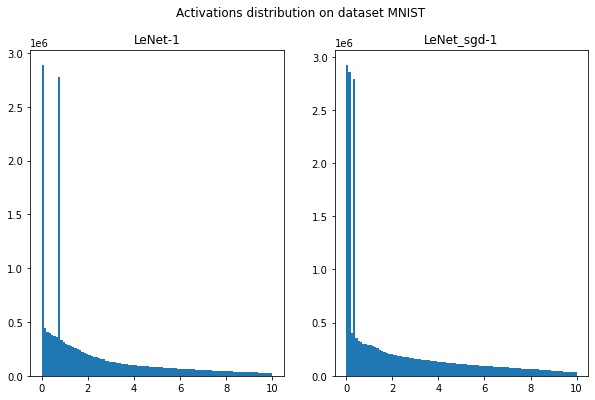

In [340]:
#!g1.1
test_iterator = test_iterator_1
model1 = LeNet(10)
model2 = LeNet(10)
name1 = 'LeNet-1'
name2 = 'LeNet_sgd-1'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset MNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

FMNIST:

Zero activations on LeNet-2: 26860901/46840000
Zero activations on LeNet_sgd-2: 25715484/46840000


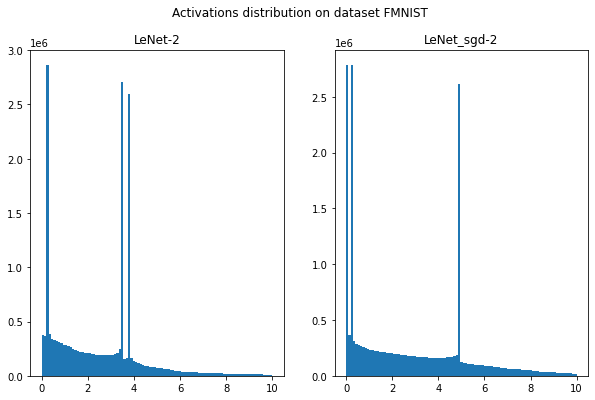

In [341]:
#!g1.1
test_iterator = test_iterator_2
model1 = LeNet(10)
model2 = LeNet(10)
name1 = 'LeNet-2'
name2 = 'LeNet_sgd-2'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset FMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

KMNIST:

Zero activations on LeNet-3: 32288783/46840000
Zero activations on LeNet_sgd-3: 23629637/46840000


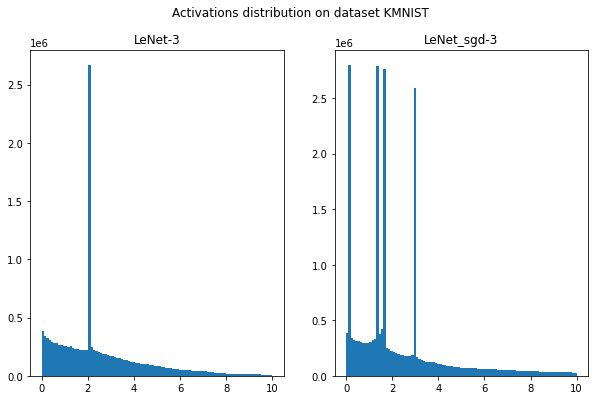

In [342]:
#!g1.1
test_iterator = test_iterator_3
model1 = LeNet(10)
model2 = LeNet(10)
name1 = 'LeNet-3'
name2 = 'LeNet_sgd-3'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset KMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

**Вывод:** можно было бы лучше подобрать параметры для оптимизатора SGD, но качество, кроме датасета MNIST, где не хватило эпох для обучения, осталось примерно тем же. Разницы между оптимизаторами почти нет за исключением того, что SGD даёт более длинные хвосты.

#### Wide vs Narrow

MNIST:

In [299]:
#!g1.1
train_iterator = train_iterator_1
valid_iterator = valid_iterator_1
model1 = LeNet_wide(10)
model2 = LeNet_narrow(10)
name1 = 'LeNet_wide-1'
name2 = 'LeNet_narrow-1'

In [300]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 1.716 | Train Acc: 74.76%
	 Val. Loss: 1.586 |  Val. Acc: 87.43%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.533 | Train Acc: 93.00%
	 Val. Loss: 1.498 |  Val. Acc: 96.30%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.498 | Train Acc: 96.34%
	 Val. Loss: 1.487 |  Val. Acc: 97.42%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.492 | Train Acc: 96.91%
	 Val. Loss: 1.483 |  Val. Acc: 97.76%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.490 | Train Acc: 97.10%
	 Val. Loss: 1.487 |  Val. Acc: 97.43%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.488 | Train Acc: 97.28%
	 Val. Loss: 1.483 |  Val. Acc: 97.77%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.486 | Train Acc: 97.52%
	 Val. Loss: 1.475 |  Val. Acc: 98.56%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.485 | Train Acc: 97.62%
	 Val. Loss: 1.480 |  Val. Acc: 98.17%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.487 | Train Acc: 97.40%
	 Val. Loss: 1.477 |  Val. Acc: 98.37%
Epoch: 10 | Epoch T

In [301]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 1.651 | Train Acc: 81.83%
	 Val. Loss: 1.523 |  Val. Acc: 94.10%
Epoch: 02 | Epoch Time: 0m 21s
	Train Loss: 1.525 | Train Acc: 93.91%
	 Val. Loss: 1.506 |  Val. Acc: 95.56%
Epoch: 03 | Epoch Time: 0m 21s
	Train Loss: 1.508 | Train Acc: 95.46%
	 Val. Loss: 1.493 |  Val. Acc: 96.97%
Epoch: 04 | Epoch Time: 0m 21s
	Train Loss: 1.502 | Train Acc: 95.92%
	 Val. Loss: 1.491 |  Val. Acc: 97.09%
Epoch: 05 | Epoch Time: 0m 21s
	Train Loss: 1.497 | Train Acc: 96.53%
	 Val. Loss: 1.484 |  Val. Acc: 97.81%
Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.494 | Train Acc: 96.72%
	 Val. Loss: 1.483 |  Val. Acc: 97.78%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.494 | Train Acc: 96.77%
	 Val. Loss: 1.490 |  Val. Acc: 97.04%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.493 | Train Acc: 96.87%
	 Val. Loss: 1.491 |  Val. Acc: 96.95%
Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 1.491 | Train Acc: 97.01%
	 Val. Loss: 1.482 |  Val. Acc: 97.97%
Epoch: 10 | Epoch T

FMNIST:

In [302]:
#!g1.1
train_iterator = train_iterator_2
valid_iterator = valid_iterator_2
model1 = LeNet_wide(10)
model2 = LeNet_narrow(10)
name1 = 'LeNet_wide-2'
name2 = 'LeNet_narrow-2'

In [303]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 1.655 | Train Acc: 81.19%
	 Val. Loss: 1.507 |  Val. Acc: 95.44%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.508 | Train Acc: 95.42%
	 Val. Loss: 1.486 |  Val. Acc: 97.58%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.496 | Train Acc: 96.56%
	 Val. Loss: 1.503 |  Val. Acc: 95.86%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.492 | Train Acc: 97.00%
	 Val. Loss: 1.481 |  Val. Acc: 98.05%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.489 | Train Acc: 97.21%
	 Val. Loss: 1.481 |  Val. Acc: 98.04%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.487 | Train Acc: 97.45%
	 Val. Loss: 1.478 |  Val. Acc: 98.37%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.488 | Train Acc: 97.39%
	 Val. Loss: 1.479 |  Val. Acc: 98.20%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.487 | Train Acc: 97.46%
	 Val. Loss: 1.476 |  Val. Acc: 98.52%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.485 | Train Acc: 97.57%
	 Val. Loss: 1.478 |  Val. Acc: 98.25%
Epoch: 10 | Epoch T

In [304]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.688 | Train Acc: 78.24%
	 Val. Loss: 1.507 |  Val. Acc: 95.66%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.524 | Train Acc: 93.93%
	 Val. Loss: 1.496 |  Val. Acc: 96.57%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.510 | Train Acc: 95.22%
	 Val. Loss: 1.492 |  Val. Acc: 97.02%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.504 | Train Acc: 95.84%
	 Val. Loss: 1.491 |  Val. Acc: 97.06%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.499 | Train Acc: 96.23%
	 Val. Loss: 1.486 |  Val. Acc: 97.60%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.496 | Train Acc: 96.56%
	 Val. Loss: 1.485 |  Val. Acc: 97.60%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.495 | Train Acc: 96.66%
	 Val. Loss: 1.482 |  Val. Acc: 97.93%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.491 | Train Acc: 97.06%
	 Val. Loss: 1.480 |  Val. Acc: 98.17%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.491 | Train Acc: 96.97%
	 Val. Loss: 1.482 |  Val. Acc: 97.97%
Epoch: 10 | Epoch T

KMNIST:

In [308]:
#!g1.1
train_iterator = train_iterator_3
valid_iterator = valid_iterator_3
model1 = LeNet_wide(10)
model2 = LeNet_narrow(10)
name1 = 'LeNet_wide-3'
name2 = 'LeNet_narrow-3'

In [306]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.620 | Train Acc: 84.78%
	 Val. Loss: 1.488 |  Val. Acc: 97.45%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.504 | Train Acc: 95.93%
	 Val. Loss: 1.482 |  Val. Acc: 97.95%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.494 | Train Acc: 96.84%
	 Val. Loss: 1.478 |  Val. Acc: 98.37%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.491 | Train Acc: 97.07%
	 Val. Loss: 1.481 |  Val. Acc: 98.09%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.489 | Train Acc: 97.27%
	 Val. Loss: 1.483 |  Val. Acc: 97.82%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.485 | Train Acc: 97.69%
	 Val. Loss: 1.479 |  Val. Acc: 98.18%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.486 | Train Acc: 97.56%
	 Val. Loss: 1.474 |  Val. Acc: 98.77%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.484 | Train Acc: 97.74%
	 Val. Loss: 1.483 |  Val. Acc: 97.84%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.483 | Train Acc: 97.84%
	 Val. Loss: 1.472 |  Val. Acc: 98.99%
Epoch: 10 | Epoch T

In [309]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.679 | Train Acc: 79.14%
	 Val. Loss: 1.504 |  Val. Acc: 95.98%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.522 | Train Acc: 94.16%
	 Val. Loss: 1.500 |  Val. Acc: 96.39%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.509 | Train Acc: 95.30%
	 Val. Loss: 1.490 |  Val. Acc: 97.24%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.501 | Train Acc: 96.04%
	 Val. Loss: 1.491 |  Val. Acc: 97.01%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.500 | Train Acc: 96.20%
	 Val. Loss: 1.491 |  Val. Acc: 96.98%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.496 | Train Acc: 96.51%
	 Val. Loss: 1.493 |  Val. Acc: 96.84%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.494 | Train Acc: 96.72%
	 Val. Loss: 1.498 |  Val. Acc: 96.38%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.494 | Train Acc: 96.74%
	 Val. Loss: 1.492 |  Val. Acc: 96.82%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.492 | Train Acc: 96.91%
	 Val. Loss: 1.485 |  Val. Acc: 97.64%
Epoch: 10 | Epoch T

#### Results

Zero activations on LeNet_wide-1: 37670310/58280000
Zero activations on LeNet_narrow-1: 20639932/58280000


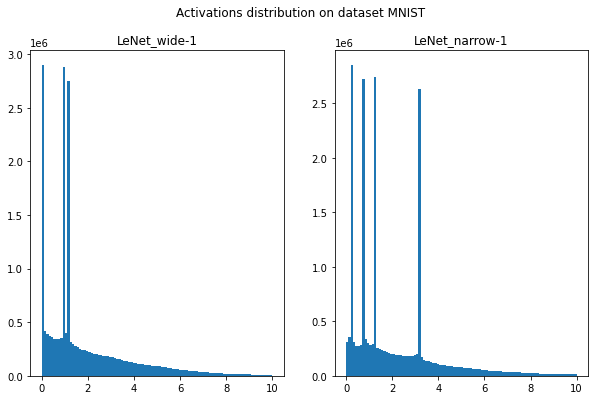

In [313]:
#!g1.1
test_iterator = test_iterator_1
model1 = LeNet_wide(10)
model2 = LeNet_narrow(10)
name1 = 'LeNet_wide-1'
name2 = 'LeNet_narrow-1'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset MNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

FMNIST:

Zero activations on LeNet_wide-2: 39921652/58280000
Zero activations on LeNet_narrow-2: 26243677/58280000


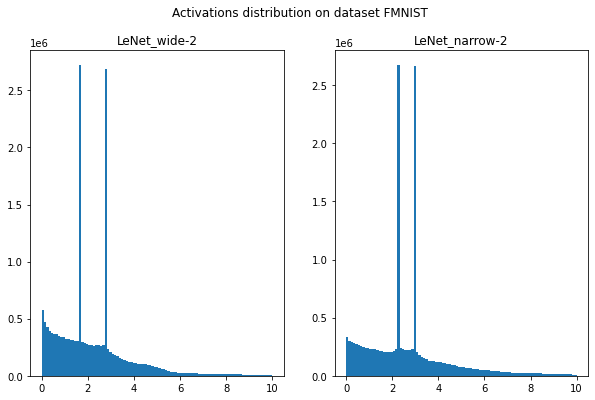

In [314]:
#!g1.1
test_iterator = test_iterator_2
model1 = LeNet_wide(10)
model2 = LeNet_narrow(10)
name1 = 'LeNet_wide-2'
name2 = 'LeNet_narrow-2'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset FMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

KMNIST:

Zero activations on LeNet_wide-3: 38107812/58280000
Zero activations on LeNet_narrow-3: 23471874/58280000


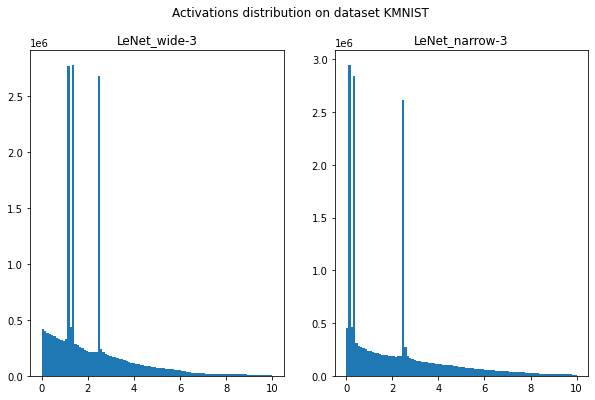

In [315]:
#!g1.1
test_iterator = test_iterator_3
model1 = LeNet_wide(10)
model2 = LeNet_narrow(10)
name1 = 'LeNet_wide-3'
name2 = 'LeNet_narrow-3'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset KMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

**Вывод:** на всех трёх датасетах отчётливо видно, что у широкой модели модули активаций больше, чем у узкой модели. В остальном примерно то же.

#### Deep vs Shallow

MNIST:

In [317]:
#!g1.1
train_iterator = train_iterator_1
valid_iterator = valid_iterator_1
model1 = LeNet_deep(10)
model2 = LeNet_shallow(10)
name1 = 'LeNet_deep-1'
name2 = 'LeNet_shallow-1'

In [318]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 1.646 | Train Acc: 81.90%
	 Val. Loss: 1.531 |  Val. Acc: 93.25%


Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.528 | Train Acc: 93.35%
	 Val. Loss: 1.500 |  Val. Acc: 96.16%


Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 1.516 | Train Acc: 94.49%
	 Val. Loss: 1.506 |  Val. Acc: 95.48%


Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.510 | Train Acc: 95.09%
	 Val. Loss: 1.504 |  Val. Acc: 95.72%


Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.504 | Train Acc: 95.72%
	 Val. Loss: 1.491 |  Val. Acc: 97.03%


Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.502 | Train Acc: 95.85%
	 Val. Loss: 1.489 |  Val. Acc: 97.18%


Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 1.499 | Train Acc: 96.25%
	 Val. Loss: 1.494 |  Val. Acc: 96.73%


Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 1.500 | Train Acc: 96.15%
	 Val. Loss: 1.488 |  Val. Acc: 97.33%


Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 1.500 | Train Acc: 96.14%
	 Val. Loss: 1.483 |  Val. Acc: 97.77%


Epoch: 10 | Epoch Time: 0m 24s
	Train Loss: 1.501 | Train Acc: 95.97%
	 Val. Loss: 1.500 |  Val. Acc: 96.07%



In [319]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.681 | Train Acc: 79.30%
	 Val. Loss: 1.511 |  Val. Acc: 95.59%


Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 1.521 | Train Acc: 94.49%
	 Val. Loss: 1.503 |  Val. Acc: 95.99%


Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.508 | Train Acc: 95.58%
	 Val. Loss: 1.489 |  Val. Acc: 97.36%


Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.500 | Train Acc: 96.25%
	 Val. Loss: 1.498 |  Val. Acc: 96.47%


Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.497 | Train Acc: 96.53%
	 Val. Loss: 1.486 |  Val. Acc: 97.65%


Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 1.495 | Train Acc: 96.71%
	 Val. Loss: 1.488 |  Val. Acc: 97.26%


Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 1.492 | Train Acc: 97.05%
	 Val. Loss: 1.483 |  Val. Acc: 97.91%


Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.489 | Train Acc: 97.27%
	 Val. Loss: 1.482 |  Val. Acc: 97.98%


Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.488 | Train Acc: 97.37%
	 Val. Loss: 1.483 |  Val. Acc: 97.83%


Epoch: 10 | Epoch Time: 0m 22s
	Train Loss: 1.488 | Train Acc: 97.39%
	 Val. Loss: 1.477 |  Val. Acc: 98.46%



FMNIST:

In [320]:
#!g1.1
train_iterator = train_iterator_2
valid_iterator = valid_iterator_2
model1 = LeNet_deep(10)
model2 = LeNet_shallow(10)
name1 = 'LeNet_deep-2'
name2 = 'LeNet_shallow-2'

In [321]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 1.816 | Train Acc: 64.66%
	 Val. Loss: 1.691 |  Val. Acc: 76.97%


Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 1.616 | Train Acc: 84.61%
	 Val. Loss: 1.510 |  Val. Acc: 95.26%


Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 1.515 | Train Acc: 94.69%
	 Val. Loss: 1.492 |  Val. Acc: 96.95%


Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 1.504 | Train Acc: 95.76%
	 Val. Loss: 1.489 |  Val. Acc: 97.24%


Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 1.501 | Train Acc: 96.05%
	 Val. Loss: 1.493 |  Val. Acc: 96.89%


Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 1.497 | Train Acc: 96.37%
	 Val. Loss: 1.484 |  Val. Acc: 97.72%


Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 1.496 | Train Acc: 96.57%
	 Val. Loss: 1.489 |  Val. Acc: 97.14%


Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 1.497 | Train Acc: 96.39%
	 Val. Loss: 1.481 |  Val. Acc: 98.00%


Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 1.494 | Train Acc: 96.68%
	 Val. Loss: 1.480 |  Val. Acc: 98.08%


Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 1.494 | Train Acc: 96.71%
	 Val. Loss: 1.485 |  Val. Acc: 97.61%



In [322]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 1.695 | Train Acc: 77.90%
	 Val. Loss: 1.510 |  Val. Acc: 95.77%


Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 1.526 | Train Acc: 93.98%
	 Val. Loss: 1.493 |  Val. Acc: 97.04%


Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 1.512 | Train Acc: 95.17%
	 Val. Loss: 1.491 |  Val. Acc: 97.27%


Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.504 | Train Acc: 95.92%
	 Val. Loss: 1.492 |  Val. Acc: 96.96%


Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.499 | Train Acc: 96.31%
	 Val. Loss: 1.484 |  Val. Acc: 97.82%


Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 1.497 | Train Acc: 96.52%
	 Val. Loss: 1.483 |  Val. Acc: 97.92%


Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.494 | Train Acc: 96.78%
	 Val. Loss: 1.481 |  Val. Acc: 98.12%


Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 1.491 | Train Acc: 97.07%
	 Val. Loss: 1.479 |  Val. Acc: 98.20%


Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 1.490 | Train Acc: 97.19%
	 Val. Loss: 1.480 |  Val. Acc: 98.07%


Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 1.489 | Train Acc: 97.30%
	 Val. Loss: 1.480 |  Val. Acc: 98.23%



KMNIST:

In [323]:
#!g1.1
train_iterator = train_iterator_3
valid_iterator = valid_iterator_3
model1 = LeNet_deep(10)
model2 = LeNet_shallow(10)
name1 = 'LeNet_deep-3'
name2 = 'LeNet_shallow-3'

In [324]:
#!g1.1
train_model(model1, name1, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 1.703 | Train Acc: 76.14%
	 Val. Loss: 1.510 |  Val. Acc: 95.24%


Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 1.527 | Train Acc: 93.58%
	 Val. Loss: 1.497 |  Val. Acc: 96.53%


Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 1.508 | Train Acc: 95.40%
	 Val. Loss: 1.491 |  Val. Acc: 97.13%


Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.501 | Train Acc: 96.02%
	 Val. Loss: 1.491 |  Val. Acc: 97.00%


Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 1.500 | Train Acc: 96.11%
	 Val. Loss: 1.485 |  Val. Acc: 97.67%


Epoch: 06 | Epoch Time: 0m 24s
	Train Loss: 1.498 | Train Acc: 96.32%
	 Val. Loss: 1.486 |  Val. Acc: 97.52%


Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 1.498 | Train Acc: 96.27%
	 Val. Loss: 1.482 |  Val. Acc: 97.93%


Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 1.496 | Train Acc: 96.45%
	 Val. Loss: 1.483 |  Val. Acc: 97.83%


Epoch: 09 | Epoch Time: 0m 25s
	Train Loss: 1.494 | Train Acc: 96.69%
	 Val. Loss: 1.481 |  Val. Acc: 98.01%


Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 1.495 | Train Acc: 96.59%
	 Val. Loss: 1.483 |  Val. Acc: 97.85%



In [325]:
#!g1.1
train_model(model2, name2, n_epochs, train_iterator, valid_iterator)

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 1.663 | Train Acc: 81.03%
	 Val. Loss: 1.506 |  Val. Acc: 95.94%


Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 1.523 | Train Acc: 94.26%
	 Val. Loss: 1.493 |  Val. Acc: 96.90%


Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 1.511 | Train Acc: 95.29%
	 Val. Loss: 1.494 |  Val. Acc: 96.91%


Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 1.504 | Train Acc: 95.89%
	 Val. Loss: 1.488 |  Val. Acc: 97.41%


Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 1.500 | Train Acc: 96.23%
	 Val. Loss: 1.486 |  Val. Acc: 97.62%


Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.498 | Train Acc: 96.39%
	 Val. Loss: 1.488 |  Val. Acc: 97.41%


Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 1.495 | Train Acc: 96.78%
	 Val. Loss: 1.482 |  Val. Acc: 98.02%


Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 1.492 | Train Acc: 97.00%
	 Val. Loss: 1.481 |  Val. Acc: 98.13%


Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 1.491 | Train Acc: 97.08%
	 Val. Loss: 1.480 |  Val. Acc: 98.12%


Epoch: 10 | Epoch Time: 0m 21s
	Train Loss: 1.490 | Train Acc: 97.17%
	 Val. Loss: 1.480 |  Val. Acc: 98.09%



#### Результаты:

MNIST:

Zero activations on LeNet_deep-1: 44464567/69260000
Zero activations on LeNet_shallow-1: 29357465/69260000


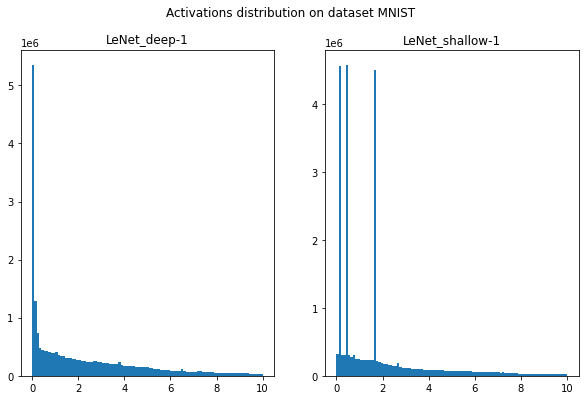

In [328]:
#!g1.1
test_iterator = test_iterator_1
model1 = LeNet_deep(10)
model2 = LeNet_shallow(10)
name1 = 'LeNet_deep-1'
name2 = 'LeNet_shallow-1'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset MNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

FMNIST:

Zero activations on LeNet_deep-2: 45024734/69260000
Zero activations on LeNet_shallow-2: 24935683/69260000


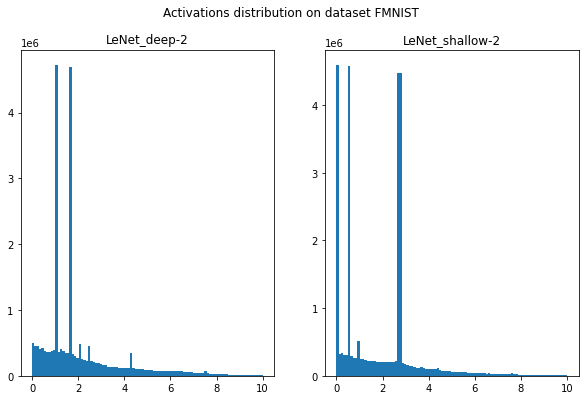

In [326]:
#!g1.1
test_iterator = test_iterator_2
model1 = LeNet_deep(10)
model2 = LeNet_shallow(10)
name1 = 'LeNet_deep-2'
name2 = 'LeNet_shallow-2'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset FMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

KMNIST:

Zero activations on LeNet_deep-3: 38899892/69260000
Zero activations on LeNet_shallow-3: 36069764/69260000


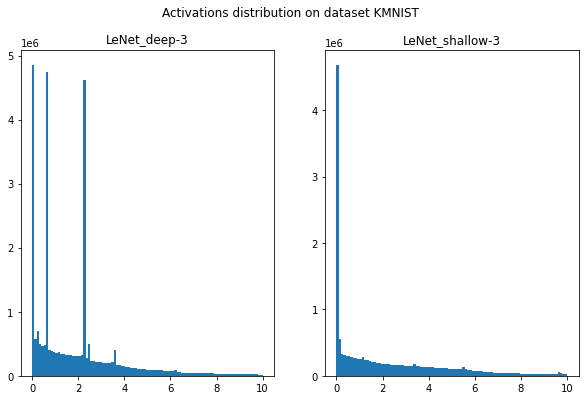

In [327]:
#!g1.1
test_iterator = test_iterator_3
model1 = LeNet_deep(10)
model2 = LeNet_shallow(10)
name1 = 'LeNet_deep-3'
name2 = 'LeNet_shallow-3'

model1.load_state_dict(torch.load(f'{name1}.pt'))
_, _, activations1 = get_activations(model1, test_iterator, criterion, device)

model2.load_state_dict(torch.load(f'{name2}.pt'))
_, _, activations2 = get_activations(model2, test_iterator, criterion, device)

nonzero_mask1 = activations1 > 10e-7
zero_quant1 = activations1.size - activations1[nonzero_mask1].size
nonzero_activations1 = activations1[nonzero_mask1]
print(f'Zero activations on {name1}: {zero_quant1}/{activations1.size}')

nonzero_mask2 = activations2 > 10e-7
zero_quant2 = activations2.size - activations2[nonzero_mask2].size
nonzero_activations2 = activations2[nonzero_mask2]
print(f'Zero activations on {name2}: {zero_quant2}/{activations1.size}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)
fig.suptitle('Activations distribution on dataset KMNIST')
ax1.set_title(name1)
ax2.set_title(name2)
ax1.hist(nonzero_activations1, bins=np.linspace(0, 10, 100))
ax2.hist(nonzero_activations2, bins=np.linspace(0, 10, 100))
plt.show()

**Вывод:** у глубокой сети есть пик в области нуля и к тому же модули активаций немного больше, чем у узкой модели.

### Дополнительно

Результат работы обычного LeNet на датасете MNIST:

In [362]:
#!g1.1
model = LeNet(10)
model.load_state_dict(torch.load(f'LeNet-1.pt'))

<All keys matched successfully>

In [364]:
#!g1.1
model.to(device)
test_loss, test_acc = evaluate(model, test_iterator_1, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.477 | Test Acc: 98.45%


In [350]:
#!g1.1
def get_predictions(model, iterator, device):
    model = model.to(device)
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [351]:
#!g1.1
images, labels, probs = get_predictions(model, test_iterator, device)

In [352]:
#!g1.1
pred_labels = torch.argmax(probs, 1)

In [353]:
#!g1.1
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

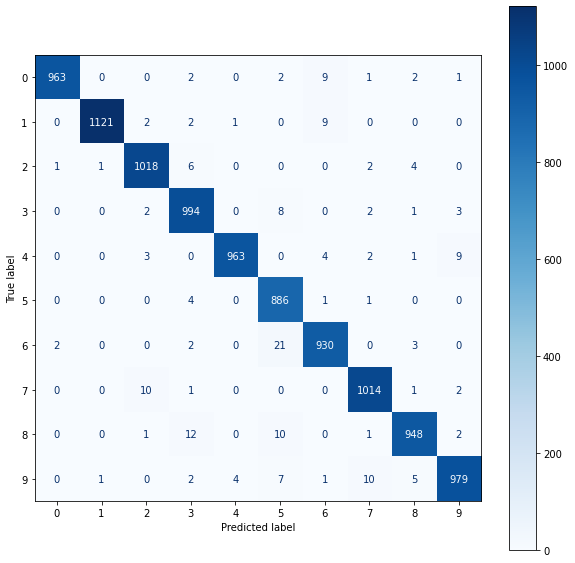

In [354]:
#!g1.1
plot_confusion_matrix(labels, pred_labels)

## Общий вывод:

* BatchNorm делает распределение активаций похожим на правую часть стандартного нормального распредления (понятно, потому что BN проводит стандартизацию).
* Dropout уменьшает пик плотности активаций в нуле.
* Начальная инициализация Xavier Normal немного уменьшает дисперсию активаций по сравнению с Kaiming Normal.
* SGD по сравнению с Adam немного увеличивает длину хвоста.
* В широких или глубоких сетях активации больше по модулю и более смещены к нулю.

Распределение активаций на предложенных датасетах MNIST, Fashion-MNIST (FMNIST) и Kuzushiji-MNIST (KMNIST) на архитектуре LeNet при варьировании архитектурных параметров, регуляризации, нормализации, способов инициализации и оптимизации рассмотрено, выводы сделаны.

## Замечание

За всего 10 эпох все сети на всех датасетах (всего сетей 27) достигли приемлемого качества в $0.97-0.99$, кроме SGD на датасете MNIST, там всего $0.88$: параметры можно было подобрать точнее, и число эпох поставить выше.